# Predict Future Sales
https://www.kaggle.com/c/competitive-data-science-predict-future-sales

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

`date_block_num` - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

Predict November 2015 - would be `date_block_num` 34 

Nov 2015 - index 34 is the 35th period

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

import seaborn as sns
sns.set()

from tensorflow import keras

In [3]:
f = 'data/sales_train.csv'
df = pd.read_csv(f)

In [4]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
df.shape

(2935849, 6)

In [6]:
df['item_cnt_day'].sum()

3648206.0

In [7]:
ts = pd.pivot_table(df, values='item_cnt_day', index=['shop_id', 'item_id'], columns='date_block_num', aggfunc=sum, fill_value=0)
ts.values.sum() == df['item_cnt_day'].sum()

True

In [8]:
# Create period range for index to period
num_periods = len(ts.columns)
period_range = pd.period_range(start='1/1/2013', periods=num_periods, freq='M')
period_range_dict = dict(zip(range(len(period_range)), period_range.strftime("%b %Y")))

In [9]:
ts.rename(columns=period_range_dict)

date_block_num   Jan 2013  Feb 2013  Mar 2013  Apr 2013  May 2013  Jun 2013  \
shop_id item_id                                                               
0       30              0        31         0         0         0         0   
        31              0        11         0         0         0         0   
        32              6        10         0         0         0         0   
        33              3         3         0         0         0         0   
        35              1        14         0         0         0         0   
...                   ...       ...       ...       ...       ...       ...   
59      22154           1         0         0         0         0         0   
        22155           0         0         0         0         0         0   
        22162           0         0         0         0         0         0   
        22164           0         0         0         0         0         0   
        22167           0         0         0         0         0         0   

date_block_num   Jul 2013  Aug 2013  Sep 2013  Oct 2013  ...  Jan 2015  \
shop_id item_id                                          ...             
0       30              0         0         0         0  ...         0   
        31              0         0         0         0  ...         0   
        32              0         0         0         0  ...         0   
        33              0         0         0         0  ...         0   
        35              0         0         0         0  ...         0   
...                   ...       ...       ...       ...  ...       ...   
59      22154           0         0         0         0  ...         0   
        22155           1         0         0         0  ...         0   
        22162           0         0         0         0  ...         0   
        22164           0         0         0         0  ...         0   
        22167           0         0         0         1  ...         0   

date_block_num   Feb 2015  Mar 2015  Apr 2015  May 2015  Jun 2015  Jul 2015  \
shop_id item_id                                                               
0       30              0         0         0         0         0         0   
        31              0         0         0         0         0         0   
        32              0         0         0         0         0         0   
        33              0         0         0         0         0         0   
        35              0         0         0         0         0         0   
...                   ...       ...       ...       ...       ...       ...   
59      22154           0         0         0         0         0         0   
        22155           0         0         0         0         0         0   
        22162           9         4         1         1         0         0   
        22164           2         1         2         0         0         1   
        22167           0         0         0         0         0         0   

date_block_num   Aug 2015  Sep 2015  Oct 2015  
shop_id item_id                                
0       30              0         0         0  
        31              0         0         0  
        32              0         0         0  
        33              0         0         0  
        35              0         0         0  
...                   ...       ...       ...  
59      22154           0         0         0  
        22155           0         0         0  
        22162           1         0         0  
        22164           0         0         0  
        22167           0         0         0  

[424124 rows x 34 columns]

In [10]:
ts.shape

(424124, 34)

In [11]:
ts.columns.name

'date_block_num'

In [11]:
ts.values.sum() == df['item_cnt_day'].sum()

True

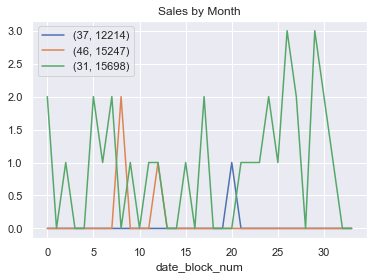

In [12]:
sample = ts.sample(3, random_state=10)
store_item_ids = sample.index.tolist()
series_samples = sample.loc[:,0:33]

for i in range(series_samples.shape[0]):
#     np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    pd.Series(series_samples.iloc[i].astype(np.float64)).plot(linewidth=1.5)

plt.title('Sales by Month')
plt.legend(store_item_ids)

In [13]:
pred_steps = 1

start_idx = 0
end_idx   = 33

first_period = start_idx
last_period  = end_idx - pred_steps

val_pred_start = last_period - pred_steps + 1
val_pred_end = last_period +1

train_pred_start = val_pred_start - pred_steps
train_pred_end = val_pred_start

In [14]:
enc_length = train_pred_start - first_period

train_enc_start = first_period
train_enc_end = train_enc_start + enc_length - 1

val_enc_start = train_enc_start + pred_steps
val_enc_end = val_enc_start + enc_length - 1

In [15]:
print('Train encoding:', period_range_dict[train_enc_start], '-', period_range_dict[train_enc_end])
print('Train prediction:', period_range_dict[train_pred_start], '-', period_range_dict[train_pred_end], '\n')

print('Val encoding:', period_range_dict[val_enc_start], '-', period_range_dict[val_enc_end])
print('Val prediction:', period_range_dict[val_pred_start], '-', period_range_dict[val_pred_end], '\n')

Train encoding: Jan 2013 - Jul 2015
Train prediction: Aug 2015 - Sep 2015 

Val encoding: Feb 2013 - Aug 2015
Val prediction: Sep 2015 - Oct 2015 



# Model

In [16]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

from keras import backend as K

Using TensorFlow backend.


In [17]:
# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last seq_length time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':1})(x)

model = Model(history_seq, pred_seq_train)

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2080

In [19]:
# for training on random sample
def gen_sample_selection(upper_bound, seed=0, n_samples=40_000):
    np.random.seed(seed)
    return np.random.choice(np.arange(0,upper_bound), n_samples, replace=False)

In [20]:
# n_samples = ts_values.shape[0]
ts_values = ts.values

stop_num = ts_values.shape[0]
# for training on random sample
sample_selection = gen_sample_selection(stop_num)


batch_size = 2**11
epochs = 10

In [21]:
def transform_series_encode(series_array):
    
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [22]:
series_array = ts.values

In [23]:
# instead of get_time_block_series
encoder_input_data = series_array[sample_selection, train_enc_start:train_enc_end]
print(encoder_input_data.shape)

encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
print(encoder_input_data.shape)

training_mean = encode_series_mean.mean()
training_mean

(40000, 30)
(40000, 30, 1)


0.2625733333333334

In [24]:
decoder_target_data = series_array[sample_selection, train_pred_start:train_pred_end]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

decoder_target_data.shape

(40000, 1, 1)

In [25]:
lagged_target_history = decoder_target_data[:,:-1,:1]
lagged_target_history

array([], shape=(40000, 0, 1), dtype=float64)

In [26]:
# For loss function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [27]:

encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
# model.compile(Adam(), loss=root_mean_squared_error)
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)


Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 13s 401us/step - loss: 0.2408 - val_loss: 0.1931
Epoch 2/10
32000/32000 [==============================] - 13s 399us/step - loss: 0.1969 - val_loss: 0.1800
Epoch 3/10
32000/32000 [==============================] - 12s 374us/step - loss: 0.1873 - val_loss: 0.1745
Epoch 4/10
32000/32000 [==============================] - 11s 357us/step - loss: 0.1777 - val_loss: 0.1687
Epoch 5/10
32000/32000 [==============================] - 11s 351us/step - loss: 0.1735 - val_loss: 0.1638
Epoch 6/10
32000/32000 [==============================] - 11s 329us/step - loss: 0.1731 - val_loss: 0.1664
Epoch 7/10
32000/32000 [==============================] - 10s 325us/step - loss: 0.1686 - val_loss: 0.1577
Epoch 8/10
32000/32000 [==============================] - 10s 325us/step - loss: 0.1652 - val_loss: 0.1582
Epoch 9/10
32000/32000 [==============================] - 10s 324us/step - loss: 0.1642 - val_

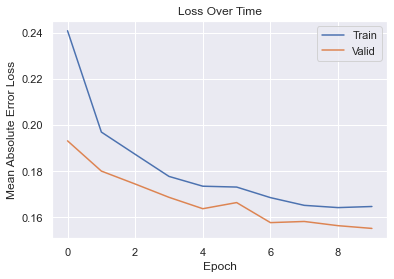

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
# plt.ylabel('Root Mean Square Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [31]:
## Save Model
model.save('models/baseline-model.h5')

# Making Predictions

#### Predict on sample

In [32]:
upper_bound = ts_values.shape[0]
sample = gen_sample_selection(upper_bound, 35, 80_000)

encoder_input_data = series_array[sample, val_enc_start:32]
print(encoder_input_data.shape)

encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
print(encoder_input_data.shape)

(80000, 31)
(80000, 31, 1)


In [33]:
%time

y_pred = model.predict(encoder_input_data).squeeze()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [34]:
ts_values = ts.values
y_true = ts_values[sample, -1].squeeze()

# Calculate Mean Absolute Error
mae = np.mean(y_true - y_pred)
print(f'mae: {mae:.3f}')

# RMSE how model is evaluated on kaggle
output_errors = np.average((y_true - y_pred) ** 2)
rmse = np.sqrt(output_errors)
print(f'rmse: {rmse:.3f}')

mae: 0.372
rmse: 3.390


### Rolling Validation - Test Score on multiple periods

In [35]:
def calc_mae(y_true, y_pred):
    return np.mean(y_true - y_pred)

def calc_rsme(y_true, y_pred):
    output_errors = np.average((y_true - y_pred) ** 2)
    rmse = np.sqrt(output_errors)
    return rmse

In [37]:
%%time

ts_values = ts.values
upper_bound = ts_values.shape[0]
sample = gen_sample_selection(upper_bound, 35, 80_000)

mae_scores  = []
rmse_scores = []

for i in range(24,33):
    encoding_start = i - 24
    
    encoder_input_data = series_array[sample, encoding_start:i]
    encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    
    y_pred = model.predict(encoder_input_data).squeeze()
    y_true = ts_values[sample, i + 1].squeeze()
    
    mae = calc_mae(y_true, y_pred)
    rmse = calc_rsme(y_true, y_pred)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    
    print(f'encoding: {period_range_dict[encoding_start]} to {period_range_dict[i]}')
    print(f'predicting: {period_range_dict[i + 1]}')
    print(f'mae: {mae:.3f}')
    print(f'rmse: {rmse:.3f}')
    print()

print('-'*10)
print(f'Average MAE: {np.mean(mae_scores):.3f}')
print(f'Average RMSE: {np.mean(rmse_scores):.3f}')
print()

encoding: Jan 2013 to Jan 2015
predicting: Feb 2015
mae: 0.352
rmse: 1.632

encoding: Feb 2013 to Feb 2015
predicting: Mar 2015
mae: 0.359
rmse: 1.989

encoding: Mar 2013 to Mar 2015
predicting: Apr 2015
mae: 0.360
rmse: 5.582

encoding: Apr 2013 to Apr 2015
predicting: May 2015
mae: 0.332
rmse: 3.764

encoding: May 2013 to May 2015
predicting: Jun 2015
mae: 0.327
rmse: 3.312

encoding: Jun 2013 to Jun 2015
predicting: Jul 2015
mae: 0.332
rmse: 3.213

encoding: Jul 2013 to Jul 2015
predicting: Aug 2015
mae: 0.339
rmse: 2.905

encoding: Aug 2013 to Aug 2015
predicting: Sep 2015
mae: 0.356
rmse: 4.588

encoding: Sep 2013 to Sep 2015
predicting: Oct 2015
mae: 0.337
rmse: 3.490

----------
Average MAE: 0.344
Average RMSE: 3.386

CPU times: user 2min 16s, sys: 17.4 s, total: 2min 33s
Wall time: 1min 26s


#### Create Submission Prediction

In [39]:
encoder_input_data = series_array
print(encoder_input_data.shape)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
print(encoder_input_data.shape)

(424124, 34)
(424124, 34, 1)


In [40]:
%time

y_pred = model.predict(encoder_input_data).squeeze()

ts[34] = y_pred

ts.head()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


date_block_num   0   1   2   3   4   5   6   7   8   9   ...  25  26  27  28  \
shop_id item_id                                          ...                   
0       30        0  31   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        31        0  11   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        32        6  10   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        33        3   3   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        35        1  14   0   0   0   0   0   0   0   0  ...   0   0   0   0   

date_block_num   29  30  31  32  33        34  
shop_id item_id                                
0       30        0   0   0   0   0  0.099218  
        31        0   0   0   0   0 -0.013207  
        32        0   0   0   0   0  0.014921  
        33        0   0   0   0   0 -0.037702  
        35        0   0   0   0   0  0.008073  

[5 rows x 35 columns]

#### Create Submission file

In [41]:
f = 'data/test.csv'
df_test = pd.read_csv(f, index_col="ID")
df_test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [42]:
submit_df = (
    pd.merge(df_test, ts[34],  how='left', left_on=['shop_id','item_id'], right_on = ['shop_id','item_id'])
    .rename(columns={34:'item_cnt_month'})
    .drop(columns=['item_id', 'shop_id'])
    .fillna(0)
)

submit_df.index.name = "ID"

submit_df.head()

,item_cnt_month
ID,
0,-0.251109
1,0.000000
2,-0.193198
3,-0.053108
4,0.000000


In [43]:
submission_filename = 'submission_baseline_rmse_loss'
submit_df.to_csv(f'submissions/{submission_filename}.csv')